In [3]:
import os, getpass

def _set_env(var: str):
    if not os.environ.get(var):
        os.environ[var] = getpass.getpass(f"{var}: ")

_set_env("OPENAI_API_KEY")

Change the paths here to give different paths

In [1]:
student_solution_path = './data/simple-scenario/student_solution.md'
model_solution_path = './data/simple-scenario/model_solution.md'
rubric_path = './data/simple-scenario/rubric.md'

In [4]:
from langchain_openai import ChatOpenAI

llm = ChatOpenAI(model="gpt-4o")

In [2]:
from langchain_core.messages import SystemMessage, HumanMessage

def classExtractor(state):
    extract_message = SystemMessage(content="Extract all class definitions from the following Java code. Include the class name, fields, methods, and constructors. Provide the full code of each class and nothing else. Only provide the code")

    with open(student_solution_path, 'r') as file:
        sContents = file.read()
    student_classes = llm.invoke([extract_message] + [HumanMessage(content=sContents)])

    with open(model_solution_path, 'r') as file:
        mContents = file.read()
    model_classes = llm.invoke([extract_message] + [HumanMessage(content=mContents)])

    return {"messages": [student_classes, model_classes]}

In [5]:
from langchain_core.messages import SystemMessage, HumanMessage

def rubricExtractor(state):
    rubric_extract_message = SystemMessage(content="Extract the relevant rubric details for each individual Java class. Be precise, this will be used for prompting other LLMs")
    messages = state["messages"]

    with open(rubric_path, 'r') as file:
        rContents = file.read()
    extracted_rubric = llm.invoke([rubric_extract_message] + [HumanMessage(content=rContents)])
    return {"messages": [extracted_rubric]}

In [6]:
from langchain_core.messages import SystemMessage, HumanMessage

def initialEvaluator(state):
    init_eval_message = SystemMessage(content="You are an expert instructor at Java code. You will be evaluating students' Java code submissions. Provide feedback on the following Java class. The user will provide you with the code written by the student, the intended model solution and the marking scheme for each class. The evaluation should not only include the correct numeric score for each criterion, but also include detailed comments about correctness, errors and suggestions for improvement in the student code. No need to calculate subtotals or totals, just assign marks for each item.")
    messages = state["messages"]
    student_code = messages[0].content
    model_code = messages[1].content
    rubric = messages[2].content

    initial_evaluation = llm.invoke([init_eval_message] + [HumanMessage(content=f"Code written by student: {student_code}\n"), HumanMessage(content=f"Model code solution: {model_code}\n"), HumanMessage(content=f"Rubric for evaluation: {rubric}")])
    return {"messages": [initial_evaluation]}

In [8]:
from langchain_core.messages import SystemMessage, HumanMessage

def reviewEvaluator(state):
    review_eval_message = SystemMessage(content="You are an professional Java instructor. A junior instructor has evaluated java code submitted by a student. You have to review his evaluation and give a final assessment. Make necessary changes. The user will provide you with the code written by the student, the intended model solution, the marking scheme for each class and the initial evaluation by your junior. No need to calculate subtotals or totals, just assign marks for each item.")
    messages = state["messages"]
    student_code = messages[0].content
    model_code = messages[1].content
    rubric = messages[2].content
    init_eval = messages[3].content

    review_evaluation = llm.invoke([review_eval_message] + [HumanMessage(content=f"Code written by student: {student_code}\n"), HumanMessage(content=f"Model code solution: {model_code}\n"), HumanMessage(content=f"Rubric for evaluation: {rubric}"), HumanMessage(content=f"Previous evaluation by junior: {init_eval}")])
    return {"messages": [review_evaluation]}

In [7]:
from langchain_core.messages import SystemMessage, HumanMessage

def marksExtractor(state):
    mark_extract_message = SystemMessage(content="You have to go through the evaluation scheme for an exam. You will also be provided the evaluation done by the instructor. Now you have to go through the evaluation and extract the marks assigned by the evaluator for the step by step evaluation criteria present in the rubric provided. You have to generate comma-seperated list of marks awarded for each class. Do not output anything else.")
    messages = state["messages"]
    rubric = messages[2].content
    final_eval = messages[4].content

    extracted_marks = llm.invoke([mark_extract_message] + [HumanMessage(content=f"Evaluation scheme or rubric: {rubric}\n"), HumanMessage(content=f"Final evaluation by instructor: {final_eval}")])
    return {"messages": [extracted_marks]}

In [10]:
from langchain_core.messages import SystemMessage, HumanMessage

def sum_marks(marks:str) -> int:
    """Takes a comma separated list of marks as input and returns their sum.

    Args:
        marks: str
    """
    marks_list = [int(mark.strip()) for mark in marks.split(",")]
    total_sum = sum(marks_list)
    return total_sum

tools = [sum_marks]
llm_with_tools = llm.bind_tools(tools)

def totalCalculator(state):
    calc_message = SystemMessage(content="Calculate the sum of the following marks: ")
    messages = state["messages"]
    marks_list = messages[5].content

    total = llm_with_tools.invoke([calc_message] + [HumanMessage(content=marks_list)])
    return {"messages": [total]}

In [9]:
def outputSaver(state):
    messages = state["messages"]
    final_eval = messages[4].content
    tool_output = messages[7].content
    with open('./final_evaluations.txt', "w") as file:
       file.write(f"The total marks awarded to the student: {tool_output}\n") 
       file.write(final_eval)
    return {"messages": []}

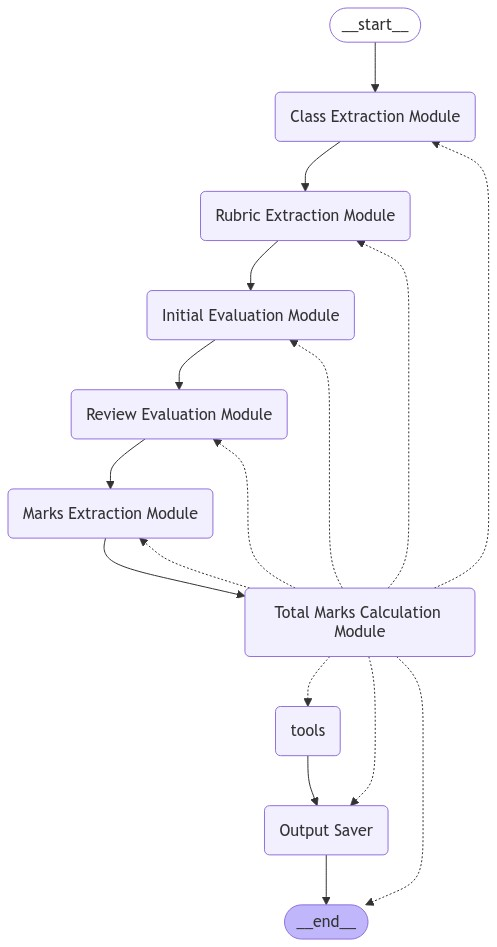

In [11]:
from langgraph.graph import START, StateGraph, END
from langgraph.graph import MessagesState
from IPython.display import Image, display
from langgraph.prebuilt import ToolNode, tools_condition

builder = StateGraph(MessagesState)

builder.add_node("Class Extraction Module", classExtractor)
builder.add_node("Rubric Extraction Module", rubricExtractor)
builder.add_node("Initial Evaluation Module", initialEvaluator)
builder.add_node("Review Evaluation Module", reviewEvaluator)
builder.add_node("Marks Extraction Module", marksExtractor)
builder.add_node("Total Marks Calculation Module", totalCalculator)
builder.add_node("tools", ToolNode(tools))
builder.add_node("Output Saver", outputSaver)

builder.add_edge(START, "Class Extraction Module")
builder.add_edge("Class Extraction Module", "Rubric Extraction Module")
builder.add_edge("Rubric Extraction Module", "Initial Evaluation Module")
builder.add_edge("Initial Evaluation Module", "Review Evaluation Module")
builder.add_edge("Review Evaluation Module", "Marks Extraction Module")
builder.add_edge("Marks Extraction Module", "Total Marks Calculation Module")
builder.add_conditional_edges(
    "Total Marks Calculation Module",
    tools_condition,
)
builder.add_edge("tools", "Output Saver")
builder.add_edge("Output Saver", END)


CodeEvaluator = builder.compile()

# Show
display(Image(CodeEvaluator.get_graph(xray=True).draw_mermaid_png()))

In [12]:
messages = []
messages = CodeEvaluator.invoke({"messages": messages})

In [13]:
for m in messages['messages']:
    m.pretty_print()

================================== Ai Message ==================================

```java
public class StringManipulator {
    public static void main(String[] args) {
        Scanner sc = new Scanner(System.in);
        System.out.print("Enter a string: ");
        String input = sc.next();

        System.out.println("Original String: " + input);
        System.out.println("Uppercase String: " + input.toLowerCase());

        String reversed = "";
        for (int i = 0; i <= input.length(); i++) { 
            reversed += input.charAt(i); 
        }
        System.out.println("Reversed String: " + reversed);

        System.out.println("Number of Characters: " + (input.length() - 1)); 
    }
}
```
================================== Ai Message ==================================

```java
public class StringManipulator {
    public static void main(String[] args) {
        Scanner sc = new Scanner(System.in);
        System.out.print("Enter a string: ");
        String input = sc.nextL